In [1]:
import sys
sys.path.insert(0, "/global/u1/p/prakharb/desilike")
import sys
sys.path.insert(0, "/global/u1/p/prakharb/cosmoprimo")
import desilike, inspect
print(inspect.getfile(desilike))
import cosmoprimo, inspect
print(inspect.getfile(cosmoprimo))

/global/u1/p/prakharb/desilike/desilike/__init__.py
/global/u1/p/prakharb/cosmoprimo/cosmoprimo/__init__.py


# Emulator Test

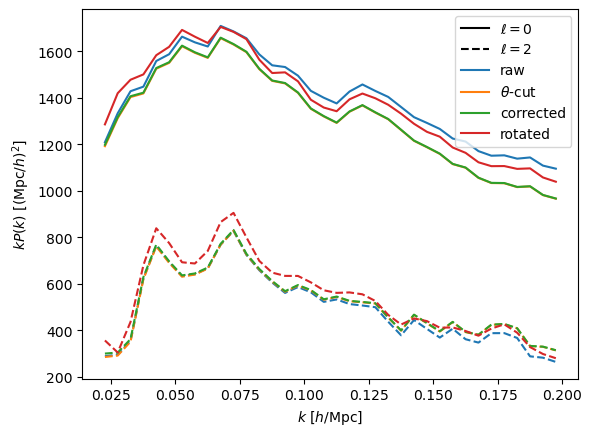

In [2]:
from pathlib import Path

tracer, zrange = 'LRG', (0.4, 0.6)
data_dir = Path('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/unblinded/desipipe/baseline_2pt/pk')

from pypower import PowerSpectrumMultipoles
raw = PowerSpectrumMultipoles.load(data_dir / f'pkpoles_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}.npy')
thetacut = PowerSpectrumMultipoles.load(data_dir / f'pkpoles_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}_thetacut0.05.npy')
corrected = PowerSpectrumMultipoles.load(data_dir / 'corrected' / f'pkpoles_corrected_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}_thetacut0.05.npy')
rotated = PowerSpectrumMultipoles.load(data_dir / 'rotated_corrected' / f'pkpoles_rotated_corrected_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}_thetacut0.05.npy')

klim = (0.02, 0.2, 0.005)
raw = raw.select(klim)
thetacut = thetacut.select(klim)
corrected = corrected.select(klim)
rotated = rotated.select(klim)

from matplotlib import pyplot as plt

ax = plt.gca()
linestyles = {0: '-', 2: '--', 4: ':'}
for ill, ell in enumerate([0, 2]):
    ax.plot([], [], linestyle=linestyles[ell], color='k', label=r'$\ell = {:d}$'.format(ell))
for ill, ell in enumerate([0, 2]):
    linestyle = linestyles[ell]
    ax.plot(raw.k, raw.k * raw(ell=ell, complex=False), color='C0', label='raw' if ill == 0 else None, linestyle=linestyle)
    ax.plot(thetacut.k, thetacut.k * thetacut(ell=ell, complex=False), color='C1', label=r'$\theta$-cut' if ill == 0 else None, linestyle=linestyle)
    ax.plot(corrected.k, corrected.k * corrected(ell=ell, complex=False), color='C2', label=r'corrected' if ill == 0 else None, linestyle=linestyle)
    ax.plot(rotated.k, rotated.k * rotated(ell=ell, complex=False), color='C3', label=r'rotated' if ill == 0 else None, linestyle=linestyle)
ax.legend(loc=1)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^2$]')
plt.show()

In [3]:
from pathlib import Path

import numpy as np
from desilike.observables import ObservableCovariance

tracer, zrange = 'LRG', (0.8, 1.1)

forfit_dir = Path('/global/cfs/cdirs/desi//survey/catalogs/Y1/LSS/iron/LSScats/v1.5/unblinded/desipipe/forfit_2pt/')
ref_fn = forfit_dir / f'forfit_power+bao-recon_syst-rotation-hod-photo_klim_0-0.02-0.20_2-0.02-0.20_{tracer}_GCcomb_z{zrange[0]:.1f}-{zrange[1]:.1f}.npy'
covariance = ObservableCovariance.load(ref_fn)

# P(k)
observable_power = covariance.observables('power')
ells_power = observable_power.projs  # (0, 2)
data_power = observable_power.view(projs=ells_power)
zeff_power = observable_power.attrs['zeff']
wmatrix_power = observable_power.attrs['wmatrix']
kin_power = observable_power.attrs['kin']

# BAO
observable_bao = covariance.observables('bao-recon')
params_bao = observable_bao.projs # qpar, qper
data_bao = observable_bao.view(projs=params_bao)
zeff_bao = observable_bao.attrs['zeff']

# Inverse covariance matrix, with all systematic corrections
invcov = covariance.inv()
# To select a part only
invcov_power = covariance.select(observables='power', select_observables=True).inv()

# Define chi2 = (d - W t)^T C^(-1) (d - W t)
def chi2(theory_power, theory_bao):
    diff = data_power - wmatrix_power.dot(theory_power)
    diff = np.append(diff, data_bao - theory_bao)
    return diff.dot(invcov).dot(diff)

In [4]:
from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate, LPTVelocileptorsTracerPowerSpectrumMultipoles, KaiserTracerPowerSpectrumMultipoles, DirectPowerSpectrumTemplate,FixedPowerSpectrumTemplate
from desilike.theories.galaxy_clustering.full_shape import  FOLPSv2TracerPowerSpectrumMultipoles,FOLPSAXTracerPowerSpectrumMultipoles, PyBirdTracerPowerSpectrumMultipoles
from desilike.observables import ObservableCovariance
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler
from desilike import setup_logging

setup_logging()

template = DirectPowerSpectrumTemplate(z=zeff_power)
# theory = LPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, tracer='ELG', prior_basis='physical')
theory = FOLPSv2TracerPowerSpectrumMultipoles(template=template, tracer='ELG',freedom='max',kernels='fk',prior_basis='standard',damping='lor')
# theory = KaiserTracerPowerSpectrumMultipoles(template=template)
covariance = ObservableCovariance.load(ref_fn)
data = covariance.observables('power')
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=covariance.select(observables=data, select_observables=True), wmatrix=data.attrs['wmatrix'], theory=theory, kin=data.attrs['kin'], ellsin=data.attrs['ellsin'], wshotnoise=data.attrs['wshotnoise'])
likelihood = ObservablesGaussianLikelihood(observables=[observable])
likelihood()

[000000.32] [0/1] 08-01 07:00  ObservableCovariance      INFO     Loading /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/unblinded/desipipe/forfit_2pt/forfit_power+bao-recon_syst-rotation-hod-photo_klim_0-0.02-0.20_2-0.02-0.20_LRG_GCcomb_z0.8-1.1.npy.
✅ Using NumPy with CPU.
Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy


/global/u1/p/prakharb/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy


Array(-709.09885563, dtype=float64)

Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy
Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy
[000036.39] [0/1] 08-01 07:01  Emulator                  INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'X_FoG_p'].
[000036.39] [0/1] 08-01 07:01  Emulator                  INFO     Found varying ['power'] and fixed ['k', 'z', 'ells', 'nd'] outputs.
[000037.49] [0/1] 08-01 07:01  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'X_FoG_p'].


/global/u1/p/prakharb/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000043.88] [0/1] 08-01 07:01  Differentiation           INFO     Using finite-differentiation for parameter h.
[000045.01] [0/1] 08-01 07:01  Differentiation           INFO     Using finite-differentiation for parameter omega_cdm.
[000046.10] [0/1] 08-01 07:01  Differentiation           INFO     Using finite-differentiation for parameter omega_b.
[000047.38] [0/1] 08-01 07:01  Differentiation           INFO     Using finite-differentiation for parameter logA.
[000049.32] [0/1] 08-01 07:01  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000049.53] [0/1] 08-01 07:01  Differentiation           INFO     Using auto-differentiation for parameter b2.
[000049.74] [0/1] 08-01 07:01  Differentiation           INFO     Using auto-differentiation for parameter bs.
[000049.95] [0/1] 08-01 07:01  Differentiation           INFO     Using auto-differentiation for parameter b3.
[000050.14] [0/1] 08-01 07:01  Differentiation           INFO     Using auto-differentiatio

[<Figure size 600x600 with 2 Axes>]

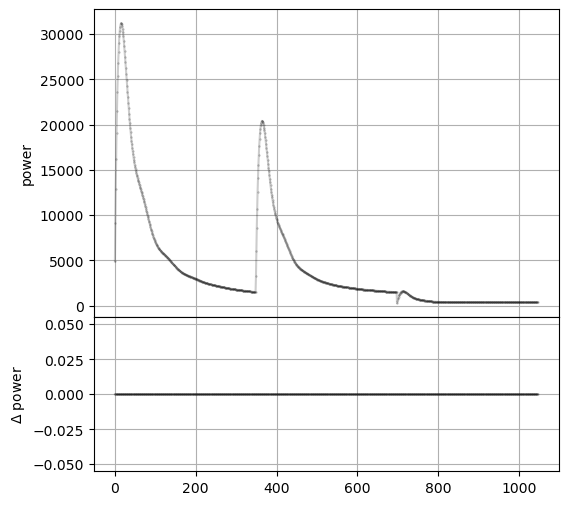

In [5]:
# import desilike, inspect
# print(inspect.getfile(desilike))
# sys.path.insert(0, "/global/u1/p/prakharb/desilike")
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine
emulator = Emulator(theory, engine=TaylorEmulatorEngine(order={'*': 2, 'sn0': 1}))  # order 2 except for sn0 (order 1 is enough)
emulator.set_samples()
emulator.fit()
emulator.plot(name='power')

In [6]:
import os
base_dir = '_tests'
folps_emulator_fn = os.path.join(base_dir, 'folpsv2_emulator.npy')
emulator.save(folps_emulator_fn)

[000169.59] [0/1] 08-01 07:03  Emulator                  INFO     Saving _tests/folpsv2_emulator.npy.
[000169.59] [0/1] 08-01 07:03  BaseConfig                INFO     Saving _tests/folpsv2_emulator.yaml.


In [7]:
from desilike.samplers import ZeusSampler

# Let's just update the observable's theory, no need to redefine the observable & likelihood
# (Internally the code will reinitialize all calculators that depend on observable)
observable.init.update(theory=emulator.to_calculator())

sampler = ZeusSampler(likelihood, save_fn='_tests/chain_fs_direct_*.npy', seed=42)
sampler.run(check={'max_eigen_gr': 0.1})

[000171.79] [0/1] 08-01 07:03  ZeusSampler               INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'X_FoG_p'].


[000173.10] [0/1] 08-01 07:03  ZeusSampler               INFO     Successfully vmap input likelihood.
[000173.57] [0/1] 08-01 07:03  ZeusSampler               INFO     Successfully jit input likelihood.
[000174.04] [0/1] 08-01 07:03  root                      INFO     Initialising ensemble of 36 walkers...
[000231.25] [0/1] 08-01 07:04  Chain                     INFO     Saving _tests/chain_fs_direct_0.npy.
[000231.26] [0/1] 08-01 07:04  ZeusSampler               INFO     Diagnostics:
[000231.32] [0/1] 08-01 07:04  Diagnostics               INFO     - max eigen Gelman-Rubin - 1 is 0.341; not < 0.1.
[000231.47] [0/1] 08-01 07:04  Diagnostics               INFO     - max diag Gelman-Rubin - 1 is 0.084.
[000232.04] [0/1] 08-01 07:04  Diagnostics               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.345.
[000232.10] [0/1] 08-01 07:04  Diagnostics               INFO     - max Geweke is 0.243.
[000232.11] [0/1] 08-01 07:04  Diagnostics               INFO     - Geweke p-value 

Traceback (most recent call last):
  File "/global/u1/p/prakharb/desilike/desilike/parameter.py", line 2341, in __setitem__
    self.data[name] = item  # list index
TypeError: list indices must be integers or slices, not Parameter

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/conda/lib/python3.10/site-packages/zeus/fwrapper.py", line 24, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/global/u1/p/prakharb/desilike/desilike/samplers/base.py", line 61, in wrapper
    toret[mask] = func(self, values)
  File "/global/u1/p/prakharb/desilike/desilike/samplers/base.py", line 150, in logposterior
    points = Samples(values[mask_finite_prior].T, params=self.varied_params)
  File "/global/u1/p/prakharb/desilike/desilike/parameter.py", line 2157, in __init__
    self[param] = value
  File "/global/u1/p/prakharb/desilike/desil

KeyboardInterrupt: 

# Profiler Test

In [9]:
import numpy as np
from matplotlib import pyplot as plt

from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate
from desilike.observables import ObservableCovariance
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler
from desilike import setup_logging

setup_logging()

template = DirectPowerSpectrumTemplate(z=zeff_power)
theory = FOLPSv2TracerPowerSpectrumMultipoles(template=template, tracer='ELG', prior_basis='physical')
covariance = ObservableCovariance.load(ref_fn)
data = covariance.observables('power')
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=covariance.select(observables=data, select_observables=True), wmatrix=data.attrs['wmatrix'], theory=theory, kin=data.attrs['kin'], ellsin=data.attrs['ellsin'], wshotnoise=data.attrs['wshotnoise'])
likelihood = ObservablesGaussianLikelihood(observables=[observable])

profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize()
print(profiles.to_stats(tablefmt='pretty'))

[000000.32] [0/1] 08-01 07:09  ObservableCovariance      INFO     Loading /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/unblinded/desipipe/forfit_2pt/forfit_power+bao-recon_syst-rotation-hod-photo_klim_0-0.02-0.20_2-0.02-0.20_LRG_GCcomb_z0.8-1.1.npy.
Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy


/global/u1/p/prakharb/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy
[000006.26] [0/1] 08-01 07:09  MinuitProfiler            INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'b1p', 'b2p', 'bsp', 'alpha0p', 'alpha2p', 'alpha4p', 'sn0p', 'sn2p', 'X_FoG_pp'].
[000012.29] [0/1] 08-01 07:09  MinuitProfiler            INFO     Could *not* jit input likelihood.
[000012.29] [0/1] 08-01 07:09  MinuitProfiler            INFO     Could *not* vmap input likelihood. Set logging level to debug (setup_logging("debug")) to get full stack trace.


/global/u1/p/prakharb/desilike/desilike/profilers/base.py:254: UserWarning: Error "CosmologyComputationError()" raised with parameters {'h': 0.8079874813466813, 'omega_cdm': 0.2121607814730017, 'omega_b': 89330.06242595213, 'logA': 3.619595816276879, 'b1p': 2.872446419987303, 'b2p': 0.5416130459787156, 'bsp': 14.920700024984479, 'alpha0p': 10.669618617924385, 'alpha2p': -5.08114485073089, 'alpha4p': 0.20831730096549306, 'sn0p': -13.801875049633075, 'sn2p': -1.792588208373066, 'X_FoG_pp': 5.2967278946807115} is caught up with -inf loglikelihood. Set logging level to debug (setup_logging("debug")) to get full stack trace.
  warnings.warn('Error "{}" raised with parameters {} is caught up with -inf loglikelihood. Set logging level to debug (setup_logging("debug")) to get full stack trace.'.format(repr(error[0]), points))
/global/u1/p/prakharb/desilike/desilike/profilers/base.py:254: UserWarning: Error "CosmologyComputationError()" raised with parameters {'h': 0.4289953790072228, 'omega_cd

+--------------------------------------+--------+---------+--------+
| chi2 / (72 - 13) = 44.34 / 59 = 0.75 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                  h                   |  True  |  0.684  | 0.016  |
|              omega_cdm               |  True  | 0.1133  | 0.0094 |
|               omega_b                |  True  | 0.02239 | 3.7e-4 |
|                 logA                 |  True  |  3.00   |  0.23  |
|                 b1p                  |  True  |  1.117  | 0.051  |
|                 b2p                  |  True  |  -1.25  |  0.59  |
|                 bsp                  |  True  |   1.4   |  1.1   |
|               alpha0p                |  True  |    3    |  10.   |
|               alpha2p                |  True  |   0.    |   12   |
|               alpha4p                |  True  |   0.    |   12   |
|                 sn0p                 |  True  |  0.03   |  0.18  |
|                 sn2p            